# Overview
Basic exploratory data analysis of the 2016 election results for Virginia's 10th congressional district

# Getting Data

Results of the 2016 election can be obtained here: http://historical.elections.virginia.gov/elections/view/80914/

There's two files for download:

* Municipality Results http://historical.elections.virginia.gov/elections/download/80914/precincts_include:0/
* Precinct Results http://historical.elections.virginia.gov/elections/download/80914/precincts_include:1/ -> `Virginia_Elections_Database__2016_U_S_House_General_Election_District_10_including_precincts.csv`

There's also a largeish (88MB) file w/ all Virginia precinct boundaries in geojson:
https://github.com/vapublicaccessproject/va-precinct-maps-2016



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch
import json

In [17]:
df = pd.read_csv('./data/Virginia_Elections_Database__2016_U_S_House_General_Election_District_10_including_precincts.csv',
                header=0,
                skiprows=[1],
                thousands=',',
                )

In [18]:
df['Label'] = df['County/City']+': '+df['Pct']
df['Percent_D'] = df['Luann L. Bennett'] / df['Total Votes Cast']
df['Percent_R'] = df['Barbara Jean Comstock'] / df['Total Votes Cast']
df['Year'] = 2016
# Period in the column name causes issues w/ Elasticsearch
df.rename(columns={'Luann L. Bennett': 'Luann L Bennett',}, inplace=True)
# We need to ALLCAPS Pct to look it up in the boundaries file (do this after we make Label)
df['Pct'] = df['Pct'].str.upper()

In [54]:
df.rename(columns={'Luann L. Bennett': 'Luann L Bennett',}, inplace=True)

In [55]:
df.head(5)

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L Bennett,All Others,Blanks,Total Votes Cast,Label,Percent_D,Percent_R,Year
0,Clarke County,-,101 - RUSSELL,-1059,406,4,0,1469,Clarke County: 101 - Russell,0.276378,0.720899,2016
1,Clarke County,-,201 - BERRYVILLE,-701,558,9,0,1268,Clarke County: 201 - Berryville,0.440063,0.552839,2016
2,Clarke County,-,301 - MILLWOOD,-639,356,4,0,999,Clarke County: 301 - Millwood,0.356356,0.639640,2016
3,Clarke County,-,302 - PINE GROVE,-306,145,3,0,454,Clarke County: 302 - Pine Grove,0.319383,0.674009,2016
4,Clarke County,-,401 - WHITE POST,-869,480,1,0,1350,Clarke County: 401 - White Post,0.355556,0.643704,2016


In [21]:
df.tail(3)

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L Bennett,All Others,Blanks,Total Votes Cast,Label,Percent_D,Percent_R,Year
213,Winchester City,-,402 - Rolling Hills,974,661,3,0,1638,Winchester City: 402 - Rolling Hills,0.403541,0.594628,2016
214,Winchester City,-,Ab - Central Absentee Precinct,572,661,2,0,1235,Winchester City: Ab - Central Absentee Precinct,0.535223,0.463158,2016
215,Winchester City,-,Provisional,2,4,0,0,6,Winchester City: Provisional,0.666667,0.333333,2016


In [20]:
df = df.drop(216)

In [56]:
# Get rid of the sub-header row (NOT IN EFFECT!!!)
#df = df.drop(0)

In [124]:
# Get rid of the sub-header row (NOT IN EFFECT!!!)
#df[['Barbara Jean Comstock','Luann L. Bennett','Pct']].drop(0).set_index('Pct')

In [125]:
df[df['Pct'] == 'Provisional']

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L. Bennett,All Others,Blanks,Total Votes Cast
8,Clarke County,-,Provisional,3,5,0,0,8
60,Fairfax County,-,Provisional,60,57,1,0,118
83,Frederick County,-,Provisional,17,12,0,0,29
178,Loudoun County,-,Provisional,77,95,0,0,172
185,Manassas City,-,Provisional,4,11,0,0,15
190,Manassas Park City,-,Provisional,3,5,0,0,8
207,Prince William County,-,Provisional,11,24,0,0,35
215,Winchester City,-,Provisional,2,4,0,0,6


In [102]:
# Are any Precincts duplicated?
df[df.duplicated(subset='Pct')]

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L. Bennett,All Others,Blanks,Total Votes Cast
59,Fairfax County,-,Ab - Central Absentee Precinct,"11,699","15,055",104,0,"26,858"
60,Fairfax County,-,Provisional,60,57,1,0,118
82,Frederick County,-,Ab - Central Absentee Precinct,"2,103","1,161",26,0,"3,290"
83,Frederick County,-,Provisional,17,12,0,0,29
177,Loudoun County,-,Ab - Central Absentee Precinct,"14,082","16,472",155,0,"30,709"
178,Loudoun County,-,Provisional,77,95,0,0,172
184,Manassas City,-,Ab - Central Absentee Precinct,"1,241","1,547",14,0,"2,802"
185,Manassas City,-,Provisional,4,11,0,0,15
189,Manassas Park City,-,Ab - Central Absentee Precinct,477,603,1,0,"1,081"
190,Manassas Park City,-,Provisional,3,5,0,0,8


In [103]:
# unique values for label columns
df['County/City'].unique()

array(['Clarke County', 'Fairfax County', 'Frederick County',
       'Loudoun County', 'Manassas City', 'Manassas Park City',
       'Prince William County', 'Winchester City', 'TOTALS'], dtype=object)

In [104]:
df['Ward'].unique()

array(['-', nan], dtype=object)

In [118]:
df['Luann L. Bennett'].unique()

array([   406,    558,    356,    145,    480,    361,    143,    441,
            5,   1483,    659,    788,    421,    483,    488,    856,
          486,    622,   1340,    680,    663,   1156,    805,    870,
          528,    919,    524,    423,    665,    623,    930,    370,
          963,    775,    547,    747,    697,   1536,   1188,    463,
          331,    726,    745,   1055,   1220,    654,    613,   1182,
          957,    962,    484,    662,    669,    865,    191,    718,
          790,    677,  15055,     57,    316,    388,    531,    320,
          195,    394,    570,    407,    234,    785,    600,    550,
          299,    521,    541,    585,    727,    612,    648,    860,
         1161,     12,    755,    639,    582,    902,   1628,    543,
          946,    470,    580,    560,    642,    914,   1119,    411,
         1038,    730,    951,    777,    833,    811,    655,    590,
          311,    436,    443,    282,    765,    594,    958,   1871,
      

In [126]:
# Make a new label that prepends City/County to Pct to account for Pct duplications
df2 = df.set_index(df['County/City']+': '+df['Pct'])

In [134]:
df2[['Barbara Jean Comstock', 'Luann L. Bennett']].sort_values('Luann L. Bennett', ascending=False)

,Barbara Jean Comstock,Luann L. Bennett
Loudoun County: Ab - Central Absentee Precinct,14082,16472
Fairfax County: Ab - Central Absentee Precinct,11699,15055
Prince William County: Ab - Central Absentee Precinct,6212,4870
Loudoun County: 313 - Pinebrook,1783,1871
Loudoun County: 314 - Legacy,1313,1761
Loudoun County: 119 - Arcola,1402,1628
Manassas City: Ab - Central Absentee Precinct,1241,1547
Fairfax County: 902 - Brookfield,929,1536
Fairfax County: 229 - Fox Mill,1421,1483
Loudoun County: 316 - Creighton's Corner,1290,1472


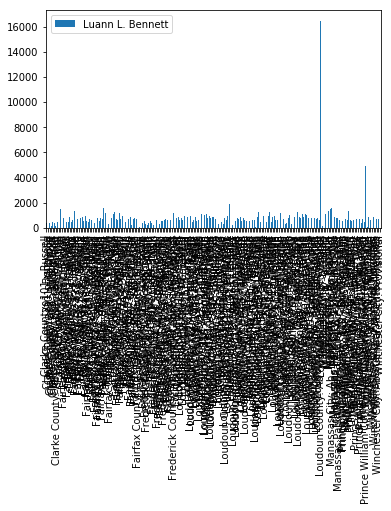

In [135]:
df2[['Luann L. Bennett']].plot.bar()

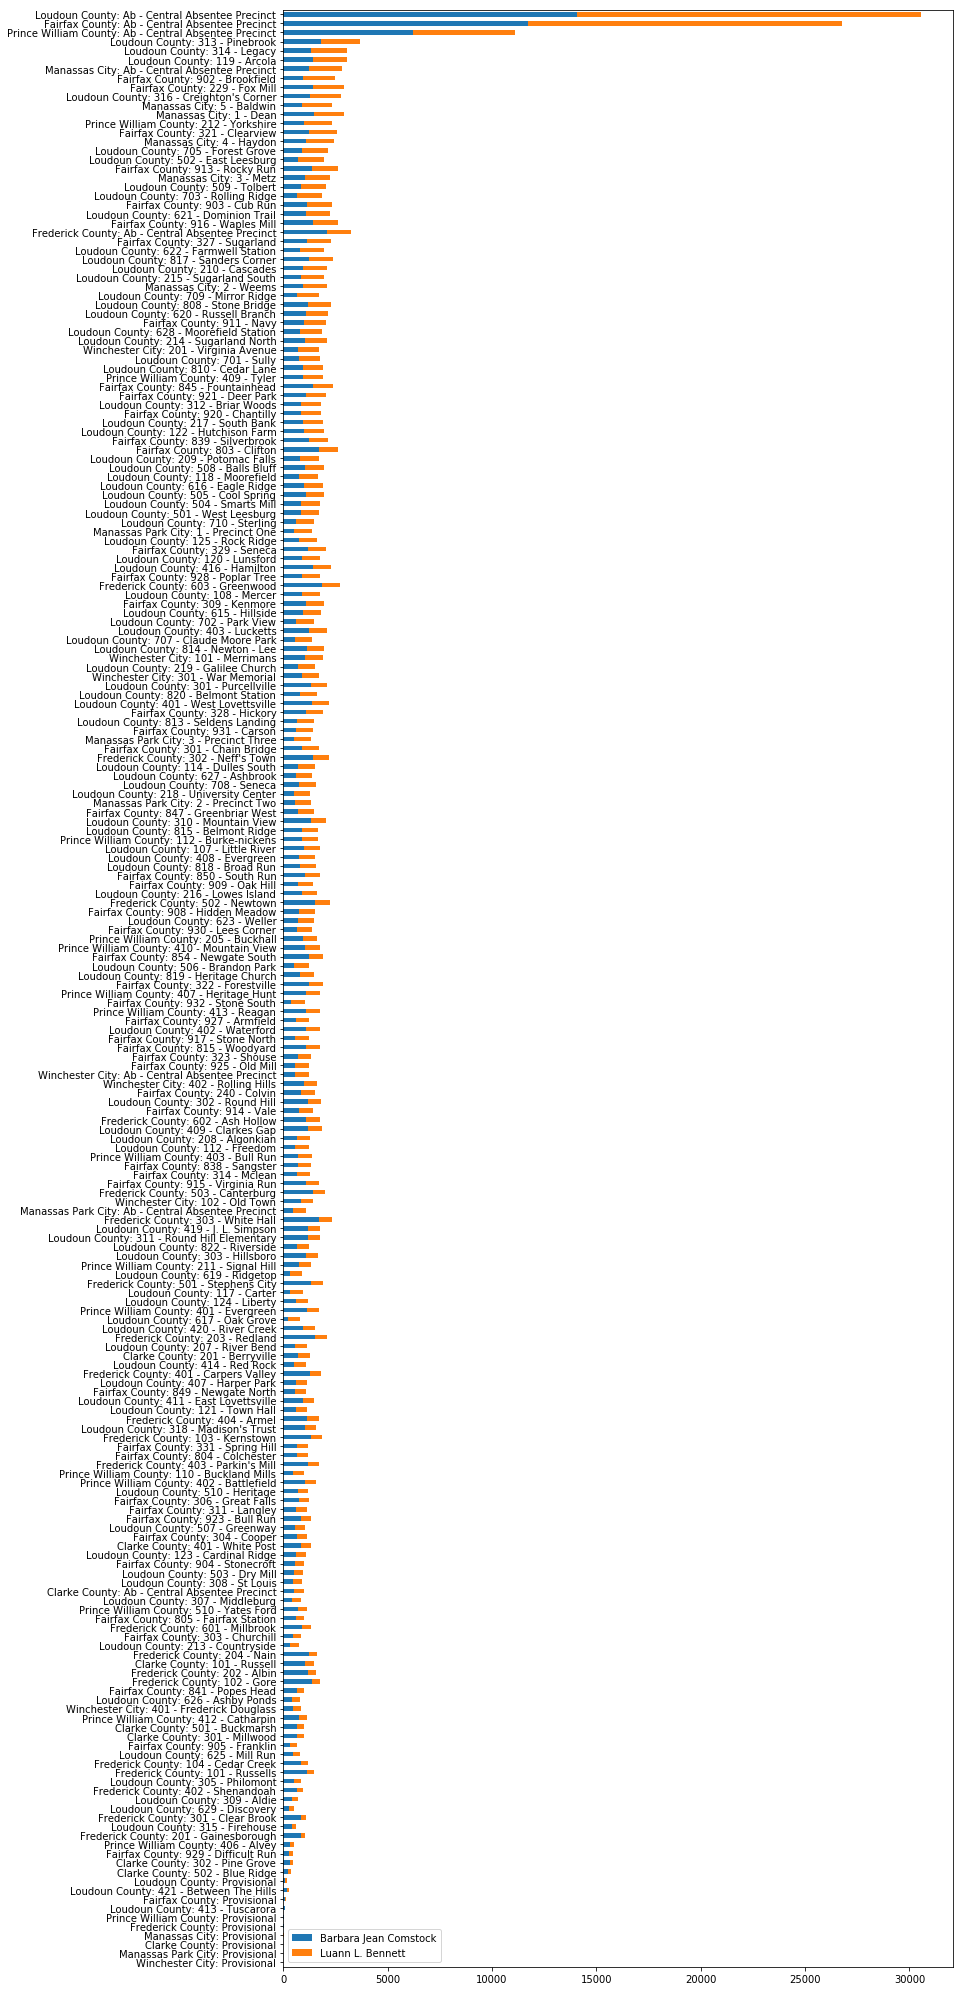

In [142]:
df2[['Barbara Jean Comstock', 'Luann L. Bennett']].sort_values('Luann L. Bennett', ascending=True).plot(figsize=(12,36), kind='barh', stacked=True)

In [148]:
df2[['Barbara Jean Comstock', 'Luann L. Bennett']].sort_values('Luann L. Bennett', ascending=False).head(4)

,Barbara Jean Comstock,Luann L. Bennett
Loudoun County: Ab - Central Absentee Precinct,14082,16472
Fairfax County: Ab - Central Absentee Precinct,11699,15055
Prince William County: Ab - Central Absentee Precinct,6212,4870
Loudoun County: 313 - Pinebrook,1783,1871


In [149]:
df2[['Barbara Jean Comstock', 'Luann L. Bennett']].sort_values('Luann L. Bennett', ascending=False)[3:].head(4)

,Barbara Jean Comstock,Luann L. Bennett
Loudoun County: 313 - Pinebrook,1783,1871
Loudoun County: 314 - Legacy,1313,1761
Loudoun County: 119 - Arcola,1402,1628
Manassas City: Ab - Central Absentee Precinct,1241,1547


In [164]:
# Drop the very large Absentee counts
# Note the weirdness around ascending=True and :-3 slice (need because the barh plots in reverse order)
df3 = df2[['Barbara Jean Comstock', 'Luann L. Bennett']].sort_values('Luann L. Bennett', ascending=True)[:-3]

In [165]:
df3.tail(4)

,Barbara Jean Comstock,Luann L. Bennett
Manassas City: Ab - Central Absentee Precinct,1241,1547
Loudoun County: 119 - Arcola,1402,1628
Loudoun County: 314 - Legacy,1313,1761
Loudoun County: 313 - Pinebrook,1783,1871


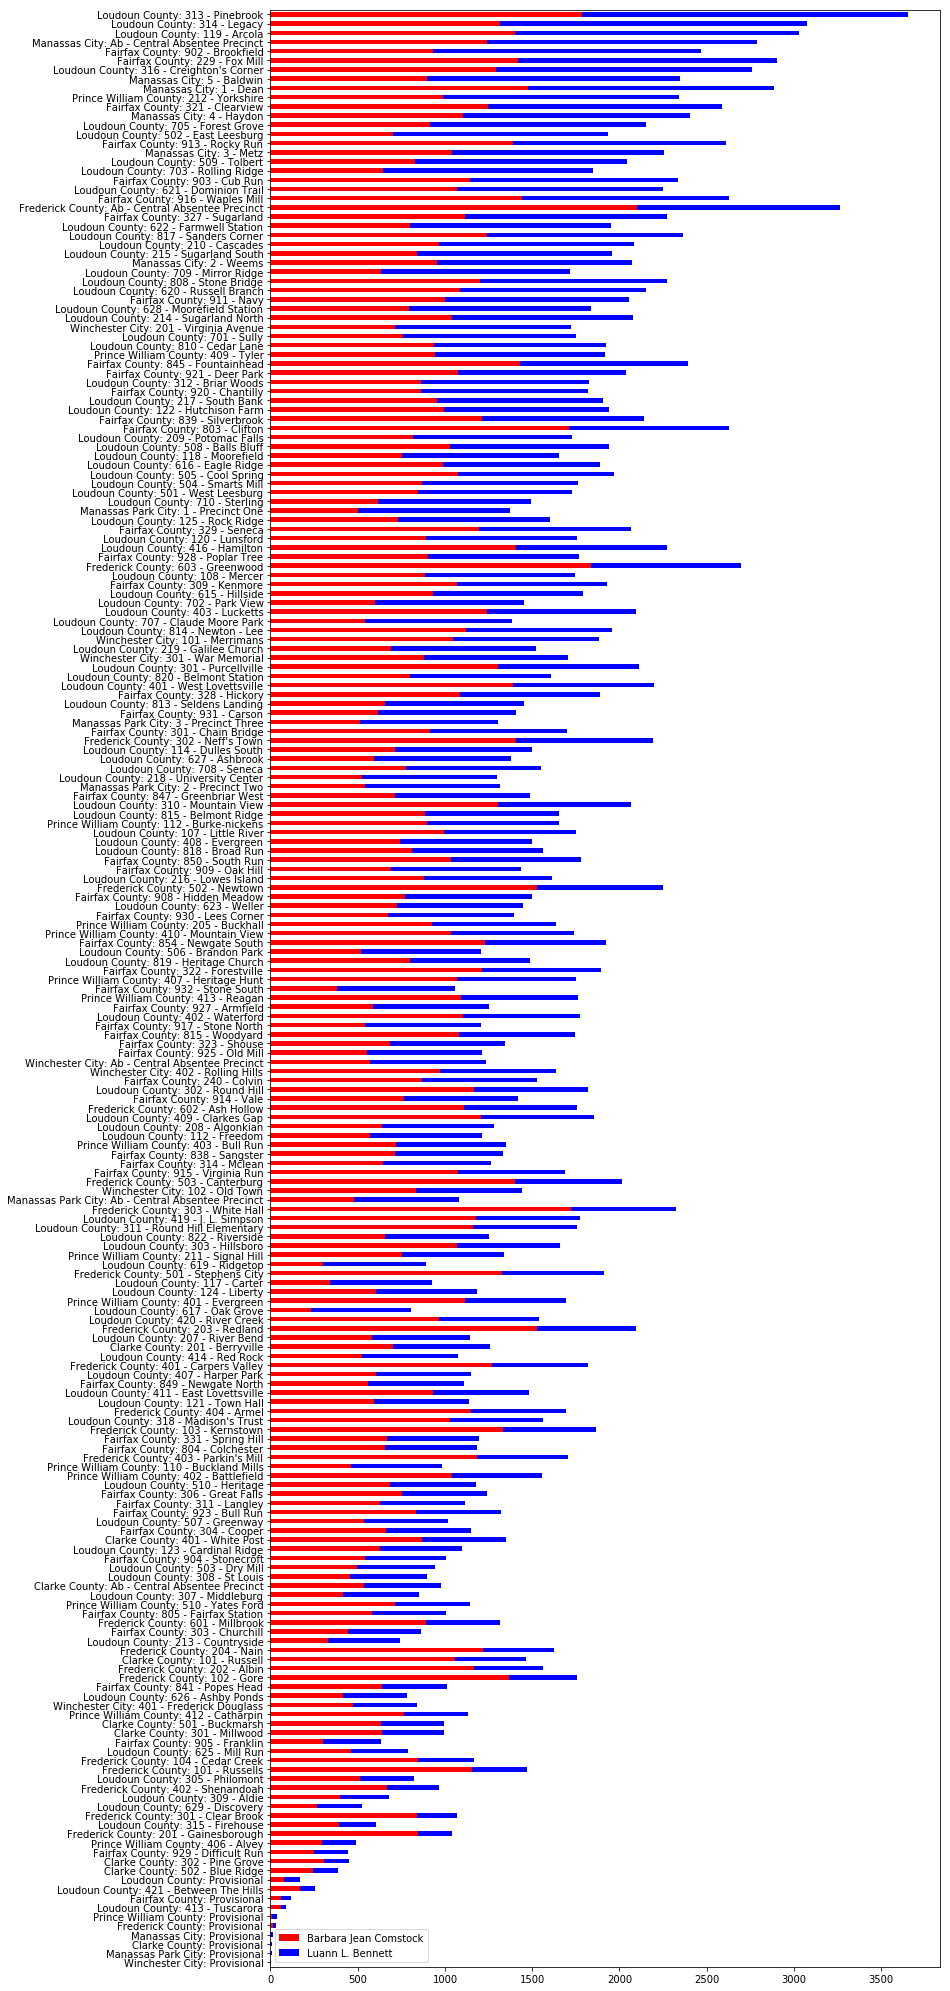

In [168]:
df3.plot(figsize=(12,36), kind='barh', stacked=True, color=('r', 'b'))

In [173]:
# Sort by Bennet %
df3['Ratio'] = df3['Luann L. Bennett']/df3['Barbara Jean Comstock']

In [175]:
df4 = df3.sort_values('Ratio')

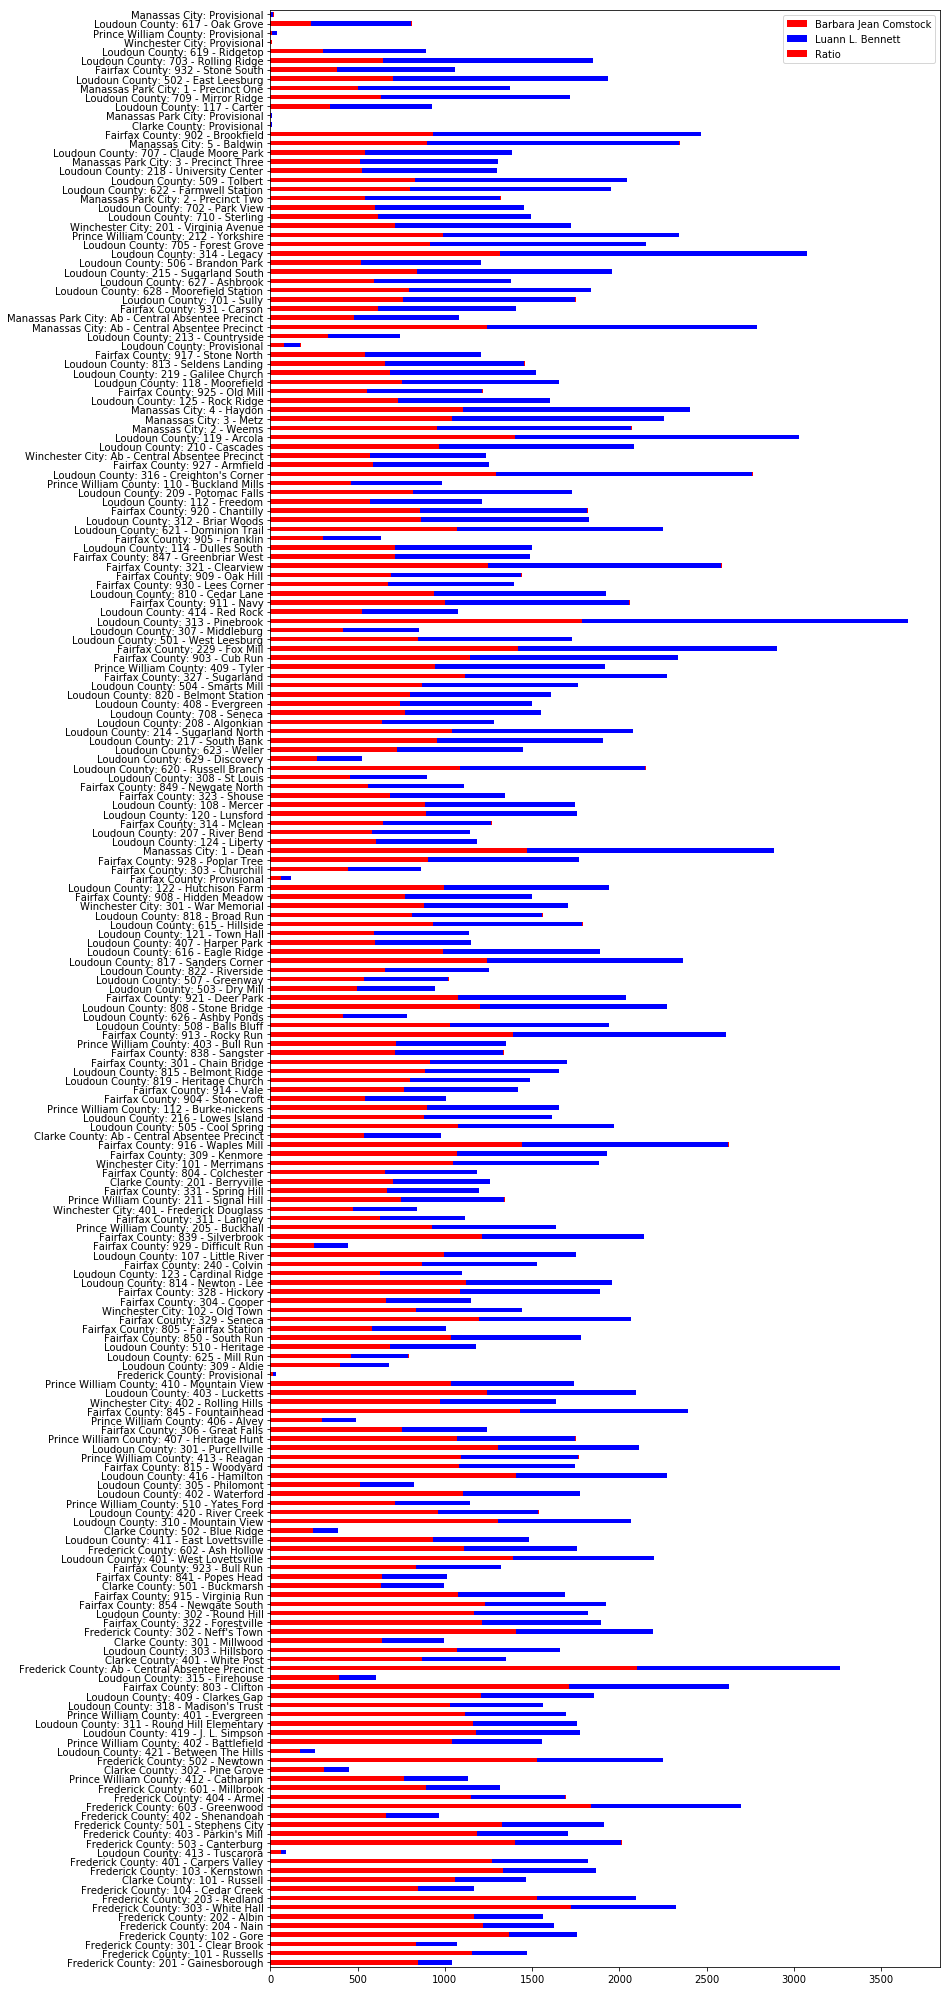

In [176]:
df4.plot(figsize=(12,36), kind='barh', stacked=True, color=('r', 'b'))

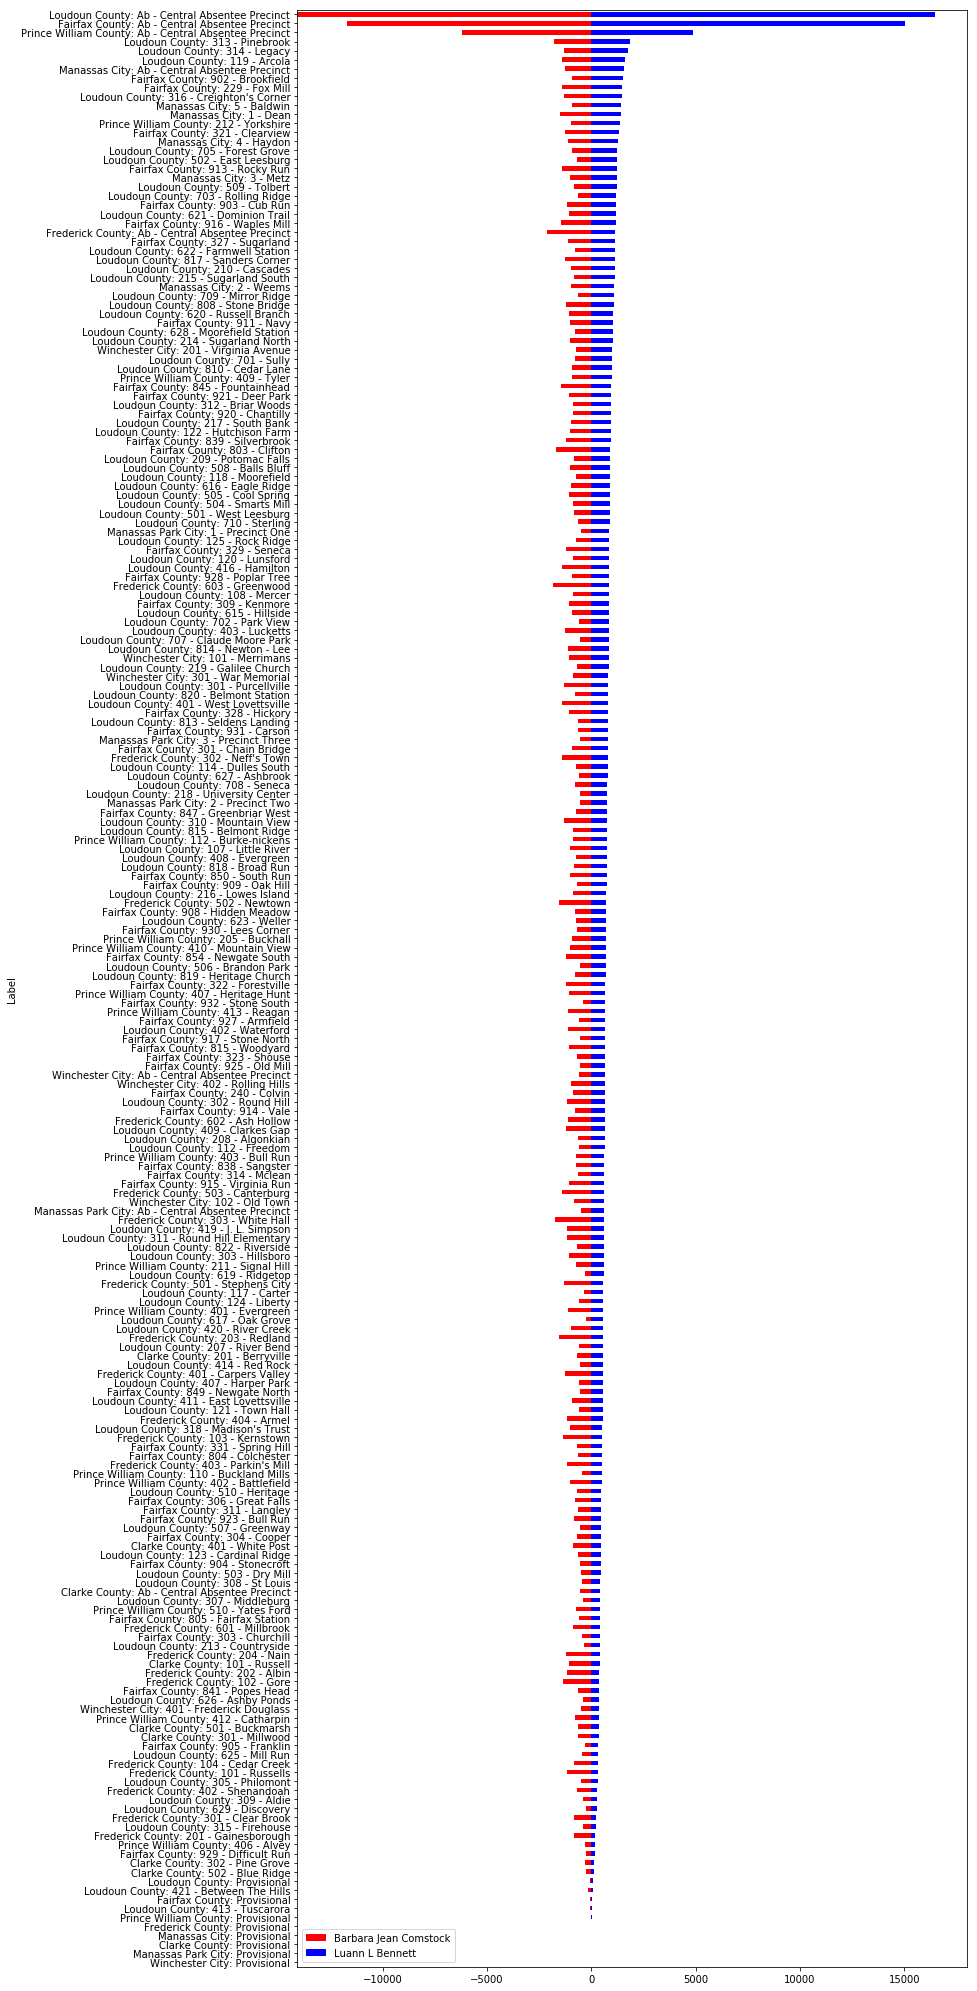

In [51]:
df[['Barbara Jean Comstock', 'Luann L Bennett']].set_index(df['Label']).sort_values('Luann L Bennett', ascending=True).plot(figsize=(12,36), kind='barh', stacked=True, color=('r', 'b'))

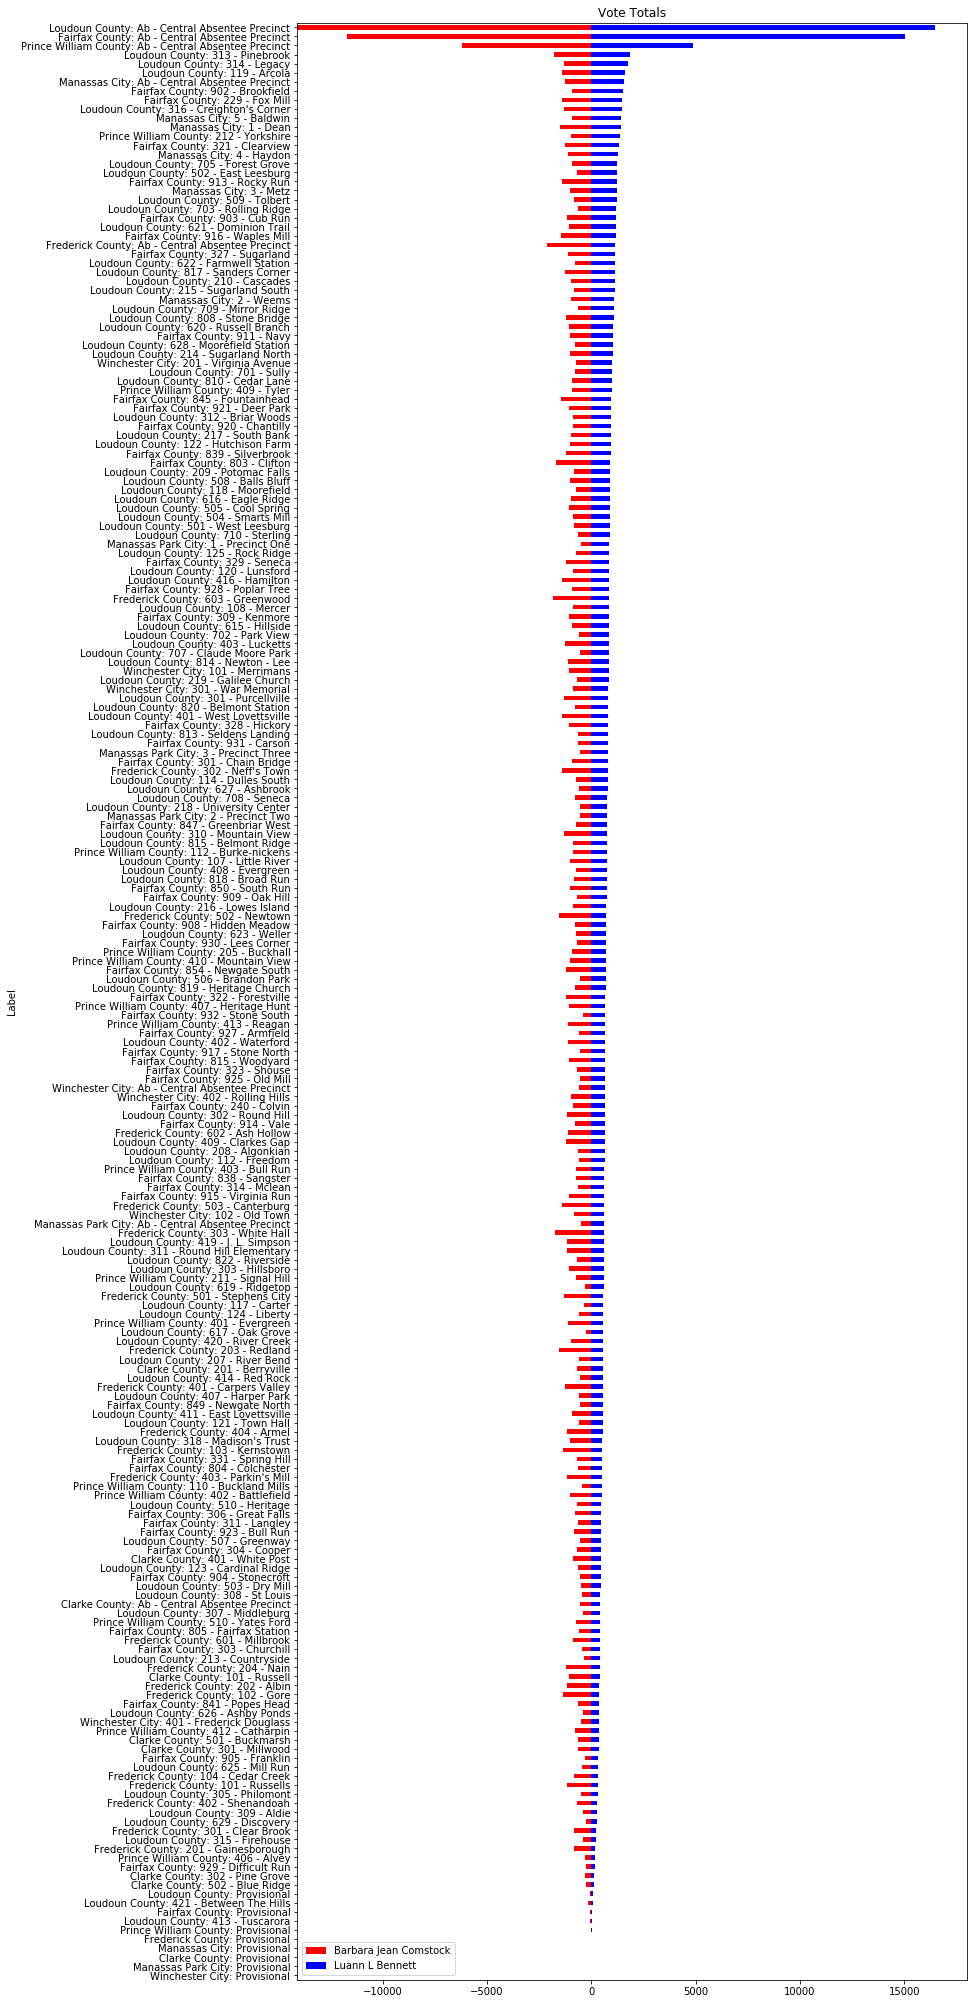

In [50]:
# With Comstock votes marked as negative
df2 = df
df2['Barbara Jean Comstock'] = -1 * df2['Barbara Jean Comstock']
df2[['Barbara Jean Comstock', 'Luann L Bennett']].set_index(df['Label']).sort_values('Luann L Bennett', ascending=True).plot(figsize=(12,36), kind='barh', stacked=True, color=('r', 'b'), title="Vote Totals")

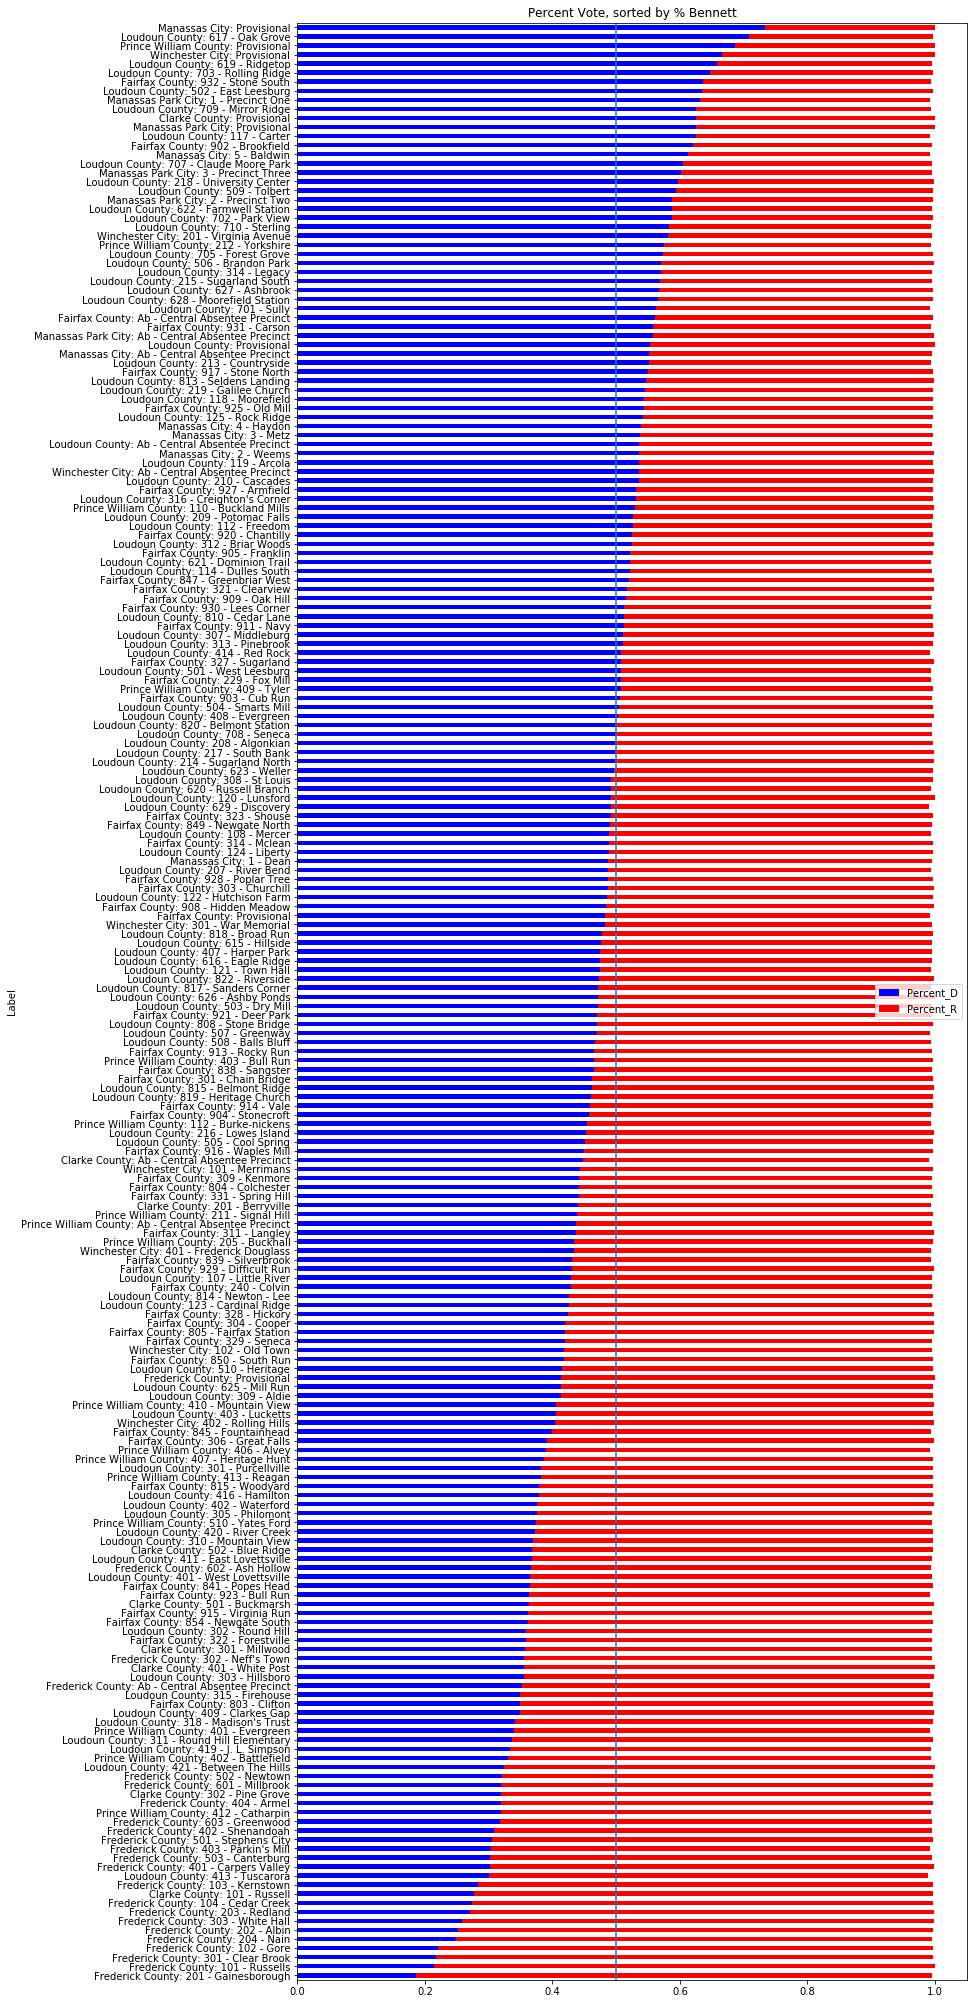

In [49]:
# Percent D vs R, sorted by % Bennett
df[['Percent_D', 'Percent_R']].set_index(df['Label']).sort_values('Percent_D', ascending=True).plot(figsize=(12,36), kind='barh', stacked=True, color=('b', 'r'), title="Percent Vote, sorted by % Bennett")
plt.axvline(0.5)

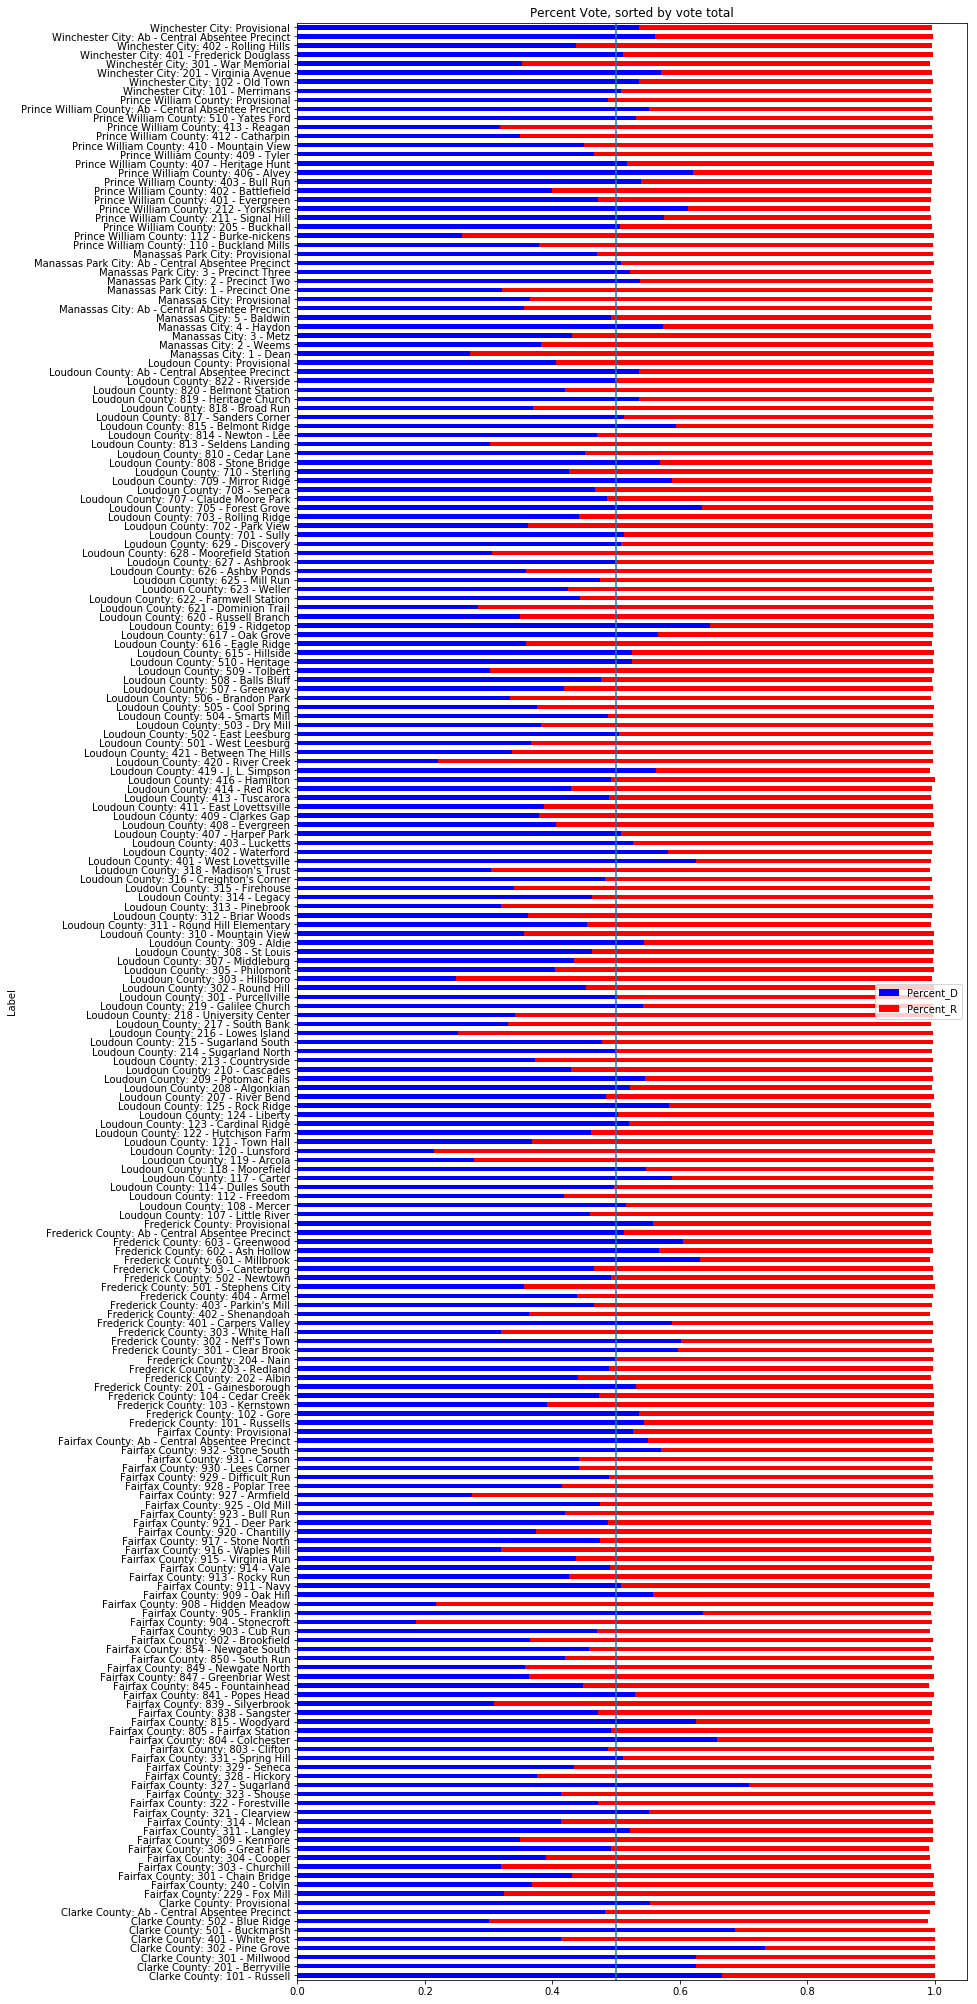

In [48]:
# Percent Vote, sorted by vote total

df.sort_values('Total Votes Cast', ascending=True).set_index(df['Label'])[['Percent_D', 'Percent_R']].plot(figsize=(12,36), kind='barh', stacked=True, color=('b','r'), title="Percent Vote, sorted by vote total" )

plt.axvline(0.5)




In [ ]:
ax = plt.subplot(111)
df.score.plot(ax=ax, kind='barh', color=('r', 'b'), title='ranking')
ax.axis('off')

In [35]:
df.sort_values(, ascending=True)

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L Bennett,All Others,Blanks,Total Votes Cast,Label,Percent_D,Percent_R,Year
215,Winchester City,-,Provisional,2,4,0,0,6,Winchester City: Provisional,0.666667,0.333333,2016
8,Clarke County,-,Provisional,3,5,0,0,8,Clarke County: Provisional,0.625000,0.375000,2016
190,Manassas Park City,-,Provisional,3,5,0,0,8,Manassas Park City: Provisional,0.625000,0.375000,2016
185,Manassas City,-,Provisional,4,11,0,0,15,Manassas City: Provisional,0.733333,0.266667,2016
83,Frederick County,-,Provisional,17,12,0,0,29,Frederick County: Provisional,0.413793,0.586207,2016
207,Prince William County,-,Provisional,11,24,0,0,35,Prince William County: Provisional,0.685714,0.314286,2016
130,Loudoun County,-,413 - Tuscarora,62,27,1,0,90,Loudoun County: 413 - Tuscarora,0.300000,0.688889,2016
60,Fairfax County,-,Provisional,60,57,1,0,118,Fairfax County: Provisional,0.483051,0.508475,2016
178,Loudoun County,-,Provisional,77,95,0,0,172,Loudoun County: Provisional,0.552326,0.447674,2016
135,Loudoun County,-,421 - Between The Hills,171,82,0,0,253,Loudoun County: 421 - Between The Hills,0.324111,0.675889,2016


In [13]:
df.head(3)

,County/City,Ward,Pct,Barbara Jean Comstock,Luann L. Bennett,All Others,Blanks,Total Votes Cast,Label,Percent_D
0,Clarke County,-,101 - Russell,1059,406,4,0,1469,Clarke County: 101 - Russell,0.276378
1,Clarke County,-,201 - Berryville,701,558,9,0,1268,Clarke County: 201 - Berryville,0.440063
2,Clarke County,-,301 - Millwood,639,356,4,0,999,Clarke County: 301 - Millwood,0.356356


In [26]:
df.loc[0].to_json()

'{"County\\/City":"Clarke County","Ward":"-","Pct":"101 - Russell","Barbara Jean Comstock":1059,"Luann L. Bennett":406,"All Others":4,"Blanks":0,"Total Votes Cast":1469,"Label":"Clarke County: 101 - Russell","Percent_D":0.2763784888,"Year":2016}'

In [15]:
# This will write it out to a file
# df.loc[0].to_json("row{}.json".format(0))

# Incorporate Precinct Boundaries

`va-precinct-maps-2016 $ cat geojson/vaprecincts2016.json | jq '.features[].properties' | less`

There are 2476 precincts in the file. They have `properties` that look like:

    {
      "Number": "623",
      "fips": 51059,
      "ID": "51059623",
      "locality": "FAIRFAX COUNTY",
      "precinct": "ALBAN"
    }

Looking just at the `precinct` field, there are duplicates. So, we'll need to actually generate a key/label to link them.

In [52]:
# Load in the data
json_file = "va-precinct-maps-2016/geojson/vaprecincts2016.json"
with open(json_file) as data_file:    
    all_precincts = json.load(data_file)

In [53]:
# Look at a result
all_precincts['features'][0]['properties']

{'ID': '51059623',
 'Number': '623',
 'fips': 51059,
 'locality': 'FAIRFAX COUNTY',
 'precinct': 'ALBAN'}

# Insert into ElasticSearch

In [30]:
# Hardcore some Elasticsearch settings
ES_HOST = 'localhost'
ES_PORT = 9200
ES_INDEX = 'va10'
ES_TYPE = 'precinct'
ES_MAPPING_FILE = "va10_mapping.json"

In [47]:
with open(ES_MAPPING_FILE) as mapping_file:    
    mapping = json.load(mapping_file)

In [48]:
mapping

{'mappings': {'precinct': {'properties': {'All Others': {'type': 'long'},
    'Barbara Jean Comstock': {'type': 'long'},
    'Blanks': {'type': 'long'},
    'County/City': {'type': 'keyword'},
    'Label': {'type': 'keyword'},
    'Luann L Bennett': {'type': 'long'},
    'Pct': {'type': 'keyword'},
    'Percent_D': {'type': 'float'},
    'Total Votes Cast': {'type': 'long'},
    'Ward': {'type': 'keyword'},
    'Year': {'type': 'date'}}}}}

In [49]:
# by default we connect to localhost:9200
es = Elasticsearch()
es.indices.create(index=ES_INDEX, body=mapping, ignore=400) # create the index, ignore if it exists

{'acknowledged': True, 'shards_acknowledged': True}

In [50]:
for i in df.index:
    es.index(index=ES_INDEX, doc_type=ES_TYPE, body=df.loc[0].to_json())

In [46]:
# es.indices.delete(index=ES_INDEX)

{'acknowledged': True}